# Preprocessing

In this notebook, we cover functionality and recommendations for preprocessing data for modelling with Hidden Markov Models (HMM). **Importantly, we assume that general preprocessing of fMRI, EEG/MEG, or physiological recordings has been performed using dedicated tools for each data modality, the GLHMM toolbox does not cover this.** The tools provided in this toolbox  only perform data wrangling to make your clean data ready for analysis. Once your data is ready for analysis, you can move on to the [Gaussian HMM](./GaussianHMM_example.ipynb) (suitable for fMRI data), the [Gaussian-Linear HMM](./GLHMM_example.ipynb) (for two sets of timeseries), or the [time-delay embedded HMM](./HMM-TDE_vs_HMM-MAR_example.ipynb) (suitable for EEG/MEG data).

**Note:** Due to rendering issues when viewing this notebook through github, internal links, like the table of contents, may not work correctly. To ensure that the notebook renders correctly, you can view it through [this link](https://nbviewer.org/github/vidaurre/glhmm/blob/main/docs/notebooks/Preprocessing.ipynb). 

Authors: Christine Ahrends <christine.ahrends@cfin.au.dk>

## Outline

0. [Preface: Acquiring and preparing data for HMM-style analyses](#preface)
1. [Preparation](#preparation)
   * [Load data](#load-data)
2. [General syntax](#general-syntax)
   * [Two sets of timeseries](#two-timeseries)
3. [Standardisation](#standardisation)
4. [Dimensionality reduction](#dimensionality-reduction)
   * [Backtransforms](#backtransforms)

## Preface: Acquiring and preparing data for HMM-style analyses <a id="preface"></a>

When preprocessing data for HMM-style analyses, it is important to keep in mind that **between-subject noise and temporal noise** may affect results more than in traditional task-based or temporal averaging analyses. For instance, poor registration in fMRI can lead to poor correspondence between parcels, which may drive the estimation to focus on artefactual between-subject differences, i.e. using states to cluster entire timeseries of subjects ([Ahrends et al., Neuroimage 2022](https://doi.org/10.1016/j.neuroimage.2022.119026)). Similarly, some parcellations and timecourse extraction methods may be better suited to capture temporal variance and less susceptible to between-subject noise than others (see [Ahrends & Vidaurre in Filippi: fMRI Techniques & Protocols, 2025](https://doi.org/10.48550/arXiv.2301.03408) for a detailed explanation). Compared to task-based analyses, where we would average out temporal noise over multiple trials, HMM-style dynamic analyses aim to find structure in temporal patterns in a data-driven way. In data that are heavily affected by temporal noise, such as motion or physiological artefacts like cardiac and respiratory activity, these patterns may dominate the more subtle patterns related to neural activity. **Temporal preprocessing**, e.g. using ICA clean-up ([Hyvärinen, IEEE 1999](https://doi.org/10.1109/72.761722), [Ablin et al., IEEE 2018](https://doi.org/10.1109/TSP.2018.2844203), [Beckmann & Smith, IEEE 2004](https://doi.org/10.1109/TMI.2003.822821)), can greatly reduce the influence of temporal artefacts on the estimation of dynamic neural patterns. Additionally, post-hoc correlation with head motion parameters and/or physiological recordings can be a good sanity-check.

## Preparation <a id="preparation"></a>
If you dont have the **GLHMM-package** installed, run the following command in your terminal:

```pip install glhmm```

**Import libraries**\
Let's start by importing the required libraries and modules.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from glhmm import glhmm, preproc

### Load data <a id="load-data"></a>
Example data for this tutorial are available for download from the OSF. This notebook will fetch the relevant data from the OSF project page using the osfclient package. If you prefer, you can also directly download the files from the [OSF project page](https://osf.io/8qcyj/?view_only=119c38072a724e0091db5ba377935666) and skip the next two cells. 

In [2]:
# checks if osfclient is installed and otherwise installs it using pip install
# skip this if you have manually downloaded the data
import sys
import pip

def install(package):
    pip.main(['install', package])

try:
    import osfclient
except ImportError:
    print('osfclient is not installed, installing it now')
    install('osfclient')

In [6]:
! osf -p 8qcyj fetch GLHMM/data.csv ./example_data/data.csv
! osf -p 8qcyj fetch GLHMM/dataX.csv ./example_data/dataX.csv
! osf -p 8qcyj fetch GLHMM/T.csv ./example_data/T.csv

100%|██████████████████████████████████| 18.2M/18.2M [00:01<00:00, 16.7Mbytes/s]
100%|████████████████████████████████████| 496k/496k [00:00<00:00, 9.67Mbytes/s]
100%|███████████████████████████████████████| 218/218 [00:00<00:00, 617kbytes/s]


Synthetic data for this example should now be in the `glhmm/docs/notebooks/example_data` folder. The files `data.csv` and `dataX.csv` contain two sets of synthetic timeseries. The data should have the shape ((no subjects/sessions * no timepoints), no features), meaning that all subjects and/or sessions have been concatenated along the first dimension. The second dimension is the number of features, e.g., the number of parcels or channels. The file `T.csv` specifies the indices in the concatenated timeseries corresponding to the beginning and end of individual subjects/sessions in the shape (no subjects, 2). In this case, we have generated timeseries for 20 subjects and 50 features as the first timeseries, and the same 20 subjects and 2 features as the second timeseries. Each subject has 1,000 timepoints. The timeseries has the shape (20000, 50) and the indices have the shape (20, 2).

Input data for the glhmm should be in numpy format. Other data types, such as .csv, can be converted to numpy using e.g. pandas, as shown below. Alternatively, the `io` module provides useful functions to load input data in the required format, e.g., from existing .mat-files. If you need to create indices from session lengths (as used in the HMM-MAR toolbox) you can use the `auxiliary.make_indices_from_T` function. 

In [7]:
data = pd.read_csv('./example_data/data.csv', header=None).to_numpy()
dataX = pd.read_csv('./example_data/dataX.csv', header=None).to_numpy()
T_t = pd.read_csv('./example_data/T.csv', header=None).to_numpy()

## General syntax <a id="general-syntax"></a>

The function `preprocess_data` contains all preprocessing tools available within the toolbox. You can configure it to do either a single or a combination of preprocessing steps appropriate for your data and model variety. Some of the most important preprocessing steps are described below, but see the [documentation](https://glhmm.readthedocs.io/en/latest/preproc.html) for all options.

The general syntax for preprocessing is: 

```
data_preprocessed, indices_preprocessed, log = preprocess_data(data, indices, preprocessing_steps)
hmm = glhmm.glhmm(K=6, preproclogY=log)
``` 

The three outputs will be the preprocessed data, the preprocessed indices (only relevant for embedding), and a log. The log keeps track of which preprocessing steps have been performed and passes them onto the HMM. This is important so that we can later relate the parameter estimates of the HMM back to the original data. 

### Two sets of timeseries <a id="two-timeseries"></a>

When working with two sets of timeseries, e.g. for fitting a GLHMM, you will need to preprocess them separately. In this case, we will save the logs for both timeseries and pass both onto the HMM as `preproclogX` and `preproclogY` for timeseries `X` and `Y`, respectively:

```
dataX_preprocessed, indices_preprocessed, logX = preprocess_data(dataX, indices, preprocessing_steps)
dataY_preprocessed, indices_preprocessed, logY = preprocess_data(dataY, indices, preprocessing_steps)
hmm = glhmm.glhmm(K=6, preproclogX=logX, preproclogY=logY)
```



## Standardisation <a id="standardisation"></a>

Standardisation refers to the process of transforming the timeseries to have mean zero and standard deviation 1. This makes sure that the state estimates in the HMM are not driven by spurious differences between subjects or channels. The function `preprocess_data` standardises the data by default. If you do not want to standardise your data, e.g. because they are already standardised, you can set `standardise=False`.

In [8]:
data_standard,_,log = preproc.preprocess_data(data, T_t)

The log is a dict containing a summary of which preprocessing steps have and which ones have not been performed:

In [11]:
log

{'fs': 1,
 'dampen_extreme_peaks': None,
 'standardise': True,
 'filter': None,
 'detrend': False,
 'onpower': False,
 'onphase': False,
 'pca': None,
 'exact_pca': True,
 'ica': None,
 'ica_algorithm': 'parallel',
 'post_standardise': None,
 'downsample': None,
 'files': None,
 'output_dir': None,
 'file_name': None,
 'file_type': 'npy',
 'lags': None,
 'p': 50,
 'N': 20}

In this case, since we have not specified any additional preprocessing steps, you can see that only `standardise` is set to `True`.

## Dimensionality reduction (PCA/ICA) <a id="dimensionality-reduction"></a>

It may sometimes be necessary to reduce the dimensionality of your data. Along the temporal axis, data can simply be downsampled by setting `downsampling` to the new frequency. This will mainly be relevant for EEG/MEG data or other recordings with high temporal resolution. Dimensionality reduction along the spatial dimension can be a crucial step to make sure the model is fitted appropriately, since too many free parameters to estimate from too few observations may cause the estimation to fail ([Ahrends et al., NeuroImage 2022](https://doi.org/10.1016/j.neuroimage.2022.119026)). This can happen, for instance, when using a very fine-grained parcellation but only few subjects, sessions, and time points (i.e., high spatial resolution but low temporal resolution and small number of subjects, as is often the case for fMRI studies). Another case for dimensionality reduction is when using the [time-delay embedded HMM](./HMM-TDE_vs_HMM-MAR_example.ipynb) ([Vidaurre et al., Nature Communications 2018](https://doi.org/10.1038/s41467-018-05316-z)), since the embedding greatly increases the number of parameters we need to estimate. As a rule of thumb, the ratio of observations to free parameters per state should not be inferior to 200. Dimensionality reduction along the spatial axis is commonly done using principal component analysis (PCA), where we will get components ordered by the amount of variance they explain, but the toolbox also offers functionality for independent component analysis (ICA). In both cases, you need to specify the number of components. 

*Note*: We do not recommend to do PCA simply default because it may affect the state estimation in unexpected ways ([Vidaurre, Plos Comput Biol 2021](https://doi.org/10.1371/journal.pcbi.1008580)).

As an example, we can reduce the first timeseries we loaded from 50 features (brain regions/channels) to 10 using PCA. To do this, we simply set `pca` to the number of components:

In [21]:
data_small, _, log = preproc.preprocess_data(data, T_t, pca=10)

Compare dimensionalities between the original data and the new, reduced version:

In [20]:
print(f"The original data have {data.shape[0]} timepoints and {data.shape[1]} channels.")
print(f"The PCA-reduced data have {data_small.shape[0]} timepoints and {data_small.shape[1]} channels.")

The original data have 20000 timepoints and 50 channels.
The PCA-reduced data have 20000 timepoints and 10 channels.


### Backtransforms <a id="backtransforms"></a>

In order to relate the state estimates back to the original data, e.g. to plot the state maps, we need to backtransform them. This is done by default when calling any of the `get_mean`, `get_beta`, `get_covariance_matrix` and `get_inverse_covariance_matrix` and their respective plural functions. 

In [30]:
hmm_small = glhmm.glhmm(K=3, covtype='full', model_beta='no', preproclogY=log)
hmm_small.train(X=None, Y=data_small, indices=T_t)

Init repetition 1 free energy = 442581.571519425
Init repetition 2 free energy = 442360.116591365
Init repetition 3 free energy = 442933.42136236414
Init repetition 4 free energy = 442984.87710992835
Init repetition 5 free energy = 442618.9072210602
Best repetition: 2
Cycle 1 free energy = 442519.97714597813
Cycle 2 free energy = 442298.9413386183
Cycle 3, free energy = 442266.87611784216, relative change = 0.12668941336304454
Cycle 4, free energy = 442247.7780633684, relative change = 0.07016208243852186
Cycle 5, free energy = 442232.33528270357, relative change = 0.053687528265280164
Cycle 6, free energy = 442218.74287235836, relative change = 0.045122389898996716
Cycle 7, free energy = 442206.40632006625, relative change = 0.0393421558151434
Cycle 8, free energy = 442195.7203524647, relative change = 0.03295526204943537
Cycle 9, free energy = 442186.6792765602, relative change = 0.027126113708118255
Cycle 10, free energy = 442178.7145000656, relative change = 0.023339139486833627
Cy

(array([[2.81809377e-01, 1.93727210e-01, 5.24463414e-01],
        [3.22802970e-01, 1.10206666e-01, 5.66990364e-01],
        [2.18000426e-01, 3.57710033e-02, 7.46228570e-01],
        ...,
        [1.03698502e-04, 2.18228623e-05, 9.99874479e-01],
        [1.88332755e-02, 2.52356740e-03, 9.78643157e-01],
        [1.20768613e-01, 1.16941143e-02, 8.67537273e-01]]),
 array([[[2.60026838e-01, 1.36058963e-03, 2.04219493e-02],
         [4.98023612e-02, 1.08499509e-01, 3.54253396e-02],
         [1.29737710e-02, 3.46567470e-04, 5.11143075e-01]],
 
        [[2.03854869e-01, 1.37836165e-03, 1.17569739e-01],
         [1.21927749e-02, 3.43252341e-02, 6.36886571e-02],
         [1.95278226e-03, 6.74075435e-05, 5.64970174e-01]],
 
        [[2.29996198e-02, 1.58803874e-04, 1.94842003e-01],
         [4.43800189e-04, 1.27584166e-03, 3.40513614e-02],
         [1.75552463e-04, 6.18813745e-06, 7.46046830e-01]],
 
        ...,
 
        [[5.41965773e-08, 2.23225988e-09, 1.04227123e-06],
         [1.58995718e-0

In [59]:
print(f"The shape of the state mean parameters before backtransforming is {hmm_small.mean[0]['Mu'].shape}")
print(f"The shape of the state covariance parameters before backtransforming is {hmm_small.mean[0]['Sigma'].shape}")

The shape of the state mean parameters before backtransforming is (10,)
The shape of the state covariance parameters before backtransforming is (10, 10)


In [61]:
state_means_orig = hmm_small.get_means()
print(f"The shape of the state means after backtransforming is {state_means_orig.shape}")

Transforming state mean back into original space
Transforming state mean back into original space
Transforming state mean back into original space
The shape of the state means after backtransforming is (50, 3)


In [62]:
state_covs_orig = hmm_small.get_covariance_matrices()
print(f"The shape of the state covariances after backtransforming is {state_covs_orig.shape}")

Transforming covariance matrix back into original space
Transforming covariance matrix back into original space
Transforming covariance matrix back into original space
The shape of the state covariances after backtransforming is (50, 50, 3)


If you do not want to backtransform the state parameters, you can set `orig_space=False`. 

In [63]:
state_means_small = hmm_small.get_means(orig_space=False)
print(f"The shape of the state means in PCA-space is {state_means_small.shape}")

The shape of the state means in PCA-space is (10, 3)


In [64]:
state_covs_small = hmm_small.get_covariance_matrices(orig_space=False)
print(f"The shape of the state covariances in PCA-space is {state_covs_small.shape}")

The shape of the state covariances in PCA-space is (10, 10, 3)


You can also access the PCA model directly if you want to inspect it:

In [50]:
pcamodel = log["pcamodel"]
print(pcamodel.explained_variance_) # variance explained by each of the 10 first PCs
print(pcamodel.components_.shape) # weights (components x original features)

[9.6878944  7.23429978 4.0630088  3.06861996 2.64162666 2.2614071
 1.81425323 1.59480337 1.28083011 1.11603696]
(10, 50)


Using the components of the PCA model, you can manually backtransform. For instance, you can reconstruct the original data from the PCA-reduced version:

In [65]:
data_recon = data_small@pcamodel.components_

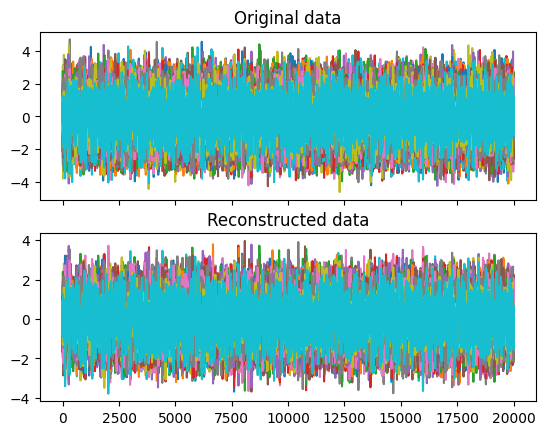

In [74]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
ax1.plot(data_standard)
ax1.set_title("Original data")
ax2.plot(data_recon)
ax2.set_title("Reconstructed data")
plt.show()